# Analysis of the attack on Diva with the Shadow Models train size set to 0.6, without clustering before the construction of the blackbox

For this attack I used adaboost instead of the random forests both for the shadow models and the attack models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from pathlib import Path
import os
import sys
import bz2
import pickle
np.random.seed(10)
# adds the visibility of the mlem module, needed to load the attack models
sys.path.append("../../../../..") 
import mlem
from mlem.ensemble import HardVotingClassifier
from mlem.utilities import report_and_confusion, split_probs_array

In [2]:
import warnings

In [3]:
BLACK_BOX_PATH = '../BB_DATA/diva_rf_noclustering.bz2'

In [40]:
def get_attack_mod(index:int, targets=[0,1], base_folder=None, one_model=False):
    """
    Args:
        index - row of the dataset on which the attack model was built
        targets (int | List(int)) - targets for the attack model.
    Returns:
        List containing the attack models (or model) for that particular index
    """
    if type(targets) is int:
        targets = [targets]
    
    loaded_models = []
    
    if one_model:
        path = f"{base_folder}/{index}/attack/one_attack/model.pkl.bz2"
        with bz2.BZ2File(path) as f:
            data = pickle.load(f)
            loaded_models.append(data)

    else:
        for t in targets:
            path = f"{base_folder}/{index}/attack/{t}/model.pkl.bz2"
            with bz2.BZ2File(path) as f:
                data = pickle.load(f)
            loaded_models.append(data)
    return loaded_models

In [5]:
with bz2.BZ2File(BLACK_BOX_PATH) as f:
    black_box = pickle.load(f)
black_box

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=100,
                       min_samples_leaf=10, min_samples_split=10,
                       n_estimators=150)

# Attack

In [6]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [7]:
BASE_BB_DATA_PATH = "../BB_DATA/diva_rf_noclustering_data_nsamples_{n_samples}.npz"

# One shadow model per label

## $5$ elements per quantile

In [8]:
BB_DATA = "../BB_DATA/clusters_representatives_quantiles_5_40.csv"

In [9]:
loaded = np.load(BASE_BB_DATA_PATH.format(n_samples=5), allow_pickle=True)
for k in loaded.keys():
    print(k, end=" ")
x_train = loaded["x_train"]
x_test = loaded["x_test"]
y_train = loaded["y_train"]
y_test = loaded["y_test"]
x_test_clustered = loaded["x_test_clustered"]
y_test_clustered = loaded["y_test_clustered"]

x_train x_test y_train y_test x_test_clustered y_test_clustered 

In [10]:
ATTACK_0, ATTACK_1 = [], []

for index in range(len(x_test_clustered)):
    atk0, atk1 = get_attack_mod(index, base_folder="/home/gerardozinno/Desktop/ExperimentsResult/EXPERIMENT_TRAINSET_SHADOW_06/diva_results_shadow_nsamples_5_06train_one_per_label/gaussian/same/")
    ATTACK_0.append(atk0)
    ATTACK_1.append(atk1)
assert (len(ATTACK_0) == len(ATTACK_1)) and (len(ATTACK_0) == len(x_test_clustered))
        
ensemble_0 = HardVotingClassifier(classifiers=ATTACK_0)
ensemble_1 = HardVotingClassifier(classifiers=ATTACK_1)

In [11]:
TRAIN_PREDICTIONS = black_box.predict_proba(x_train)
TEST_PREDICTIONS  = black_box.predict_proba(x_test)

In [12]:
TRAIN_0, TRAIN_1 = split_probs_array(TRAIN_PREDICTIONS)
TEST_0, TEST_1  = split_probs_array(TEST_PREDICTIONS)

In [13]:
IN_0 = ensemble_0.predict(TRAIN_0)
IN_1 = ensemble_1.predict(TRAIN_1)
OUT_0 = ensemble_0.predict(TEST_0)
OUT_1 = ensemble_1.predict(TEST_1)

In [14]:
INS = np.concatenate([IN_0, IN_1])
INS_LAB = np.array(["in"] * len(INS))
OUTS = np.concatenate([OUT_0, OUT_1])
OUTS_LAB = np.array(["out"] * len(OUTS))

In [15]:
number_even_in = len([x for x in INS if x == "even"])
number_even_out = len([x for x in OUTS if x == "even"])
print(f"even_in = {number_even_in/len(INS)}")
print(F"even_out = {number_even_out/len(OUTS)}")

even_in = 0.0
even_out = 0.0


In [16]:
INOUT = np.concatenate([INS, OUTS])
EVEN_MASK = INOUT != "even" # to mask away the even values
INOUT_LAB = np.concatenate([INS_LAB, OUTS_LAB])

In [17]:
print(classification_report(INOUT_LAB[EVEN_MASK], INOUT[EVEN_MASK]))

              precision    recall  f1-score   support

          in       0.70      1.00      0.82      6624
         out       0.00      0.00      0.00      2839

    accuracy                           0.70      9463
   macro avg       0.35      0.50      0.41      9463
weighted avg       0.49      0.70      0.58      9463



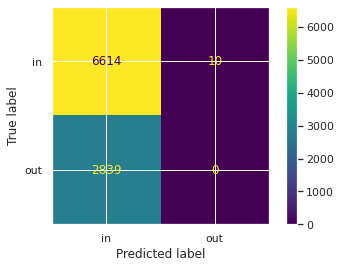

In [18]:
ConfusionMatrixDisplay.from_predictions(INOUT_LAB[EVEN_MASK], INOUT[EVEN_MASK])

### Checking if the attack models are majority classifiers


2 elem. per quantile

In [21]:
BB_DATA = "../BB_DATA/clusters_representatives_quantiles_5_40.csv"

In [23]:
loaded = np.load(BASE_BB_DATA_PATH.format(n_samples=5), allow_pickle=True)
for k in loaded.keys():
    print(k, end=" ")
x_train = loaded["x_train"]
x_test = loaded["x_test"]
y_train = loaded["y_train"]
y_test = loaded["y_test"]
x_test_clustered = loaded["x_test_clustered"]
y_test_clustered = loaded["y_test_clustered"]

x_train x_test y_train y_test x_test_clustered y_test_clustered 

In [24]:
print(len(x_test_clustered))

40


In [26]:
ATTACK_0, ATTACK_1 = [], []

for index in range(len(x_test_clustered)):
    atk0, atk1 = get_attack_mod(index, base_folder="/home/gerardozinno/Desktop/ExperimentsResult/EXPERIMENT_TRAINSET_SHADOW_06/diva_results_shadow_nsamples_5_06train_one_per_label/gaussian/same")
    ATTACK_0.append(atk0)
    ATTACK_1.append(atk1)
        
ensemble_0 = HardVotingClassifier(classifiers=ATTACK_0)
ensemble_1 = HardVotingClassifier(classifiers=ATTACK_1)

In [27]:
TRAIN_PREDICTIONS = black_box.predict_proba(x_train)
TEST_PREDICTIONS  = black_box.predict_proba(x_test)

In [28]:
TRAIN_0, TRAIN_1 = split_probs_array(TRAIN_PREDICTIONS)
TEST_0, TEST_1  = split_probs_array(TEST_PREDICTIONS)

In [29]:
IN_0 = ensemble_0.predict(TRAIN_0)
IN_1 = ensemble_1.predict(TRAIN_1)
OUT_0 = ensemble_0.predict(TEST_0)
OUT_1 = ensemble_1.predict(TEST_1)

In [30]:
INS = np.concatenate([IN_0, IN_1])
INS_LAB = np.array(["in"] * len(INS))
OUTS = np.concatenate([OUT_0, OUT_1])
OUTS_LAB = np.array(["out"] * len(OUTS))

In [31]:
number_even_in = len([x for x in INS if x == "even"])
number_even_out = len([x for x in OUTS if x == "even"])
print(f"even_in = {number_even_in/len(INS)}")
print(F"even_out = {number_even_out/len(OUTS)}")

even_in = 0.0
even_out = 0.0


In [32]:
INOUT = np.concatenate([INS, OUTS])
INOUT_LAB = np.concatenate([INS_LAB, OUTS_LAB])

              precision    recall  f1-score   support

          in       0.70      1.00      0.82      6624
         out       0.00      0.00      0.00      2839

    accuracy                           0.70      9463
   macro avg       0.35      0.50      0.41      9463
weighted avg       0.49      0.70      0.58      9463



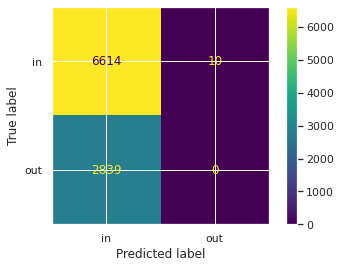

In [33]:
report_and_confusion(INOUT_LAB, INOUT)

The attack models turn out to be Majority classifiers

In [34]:
print(len(ATTACK_0))

40


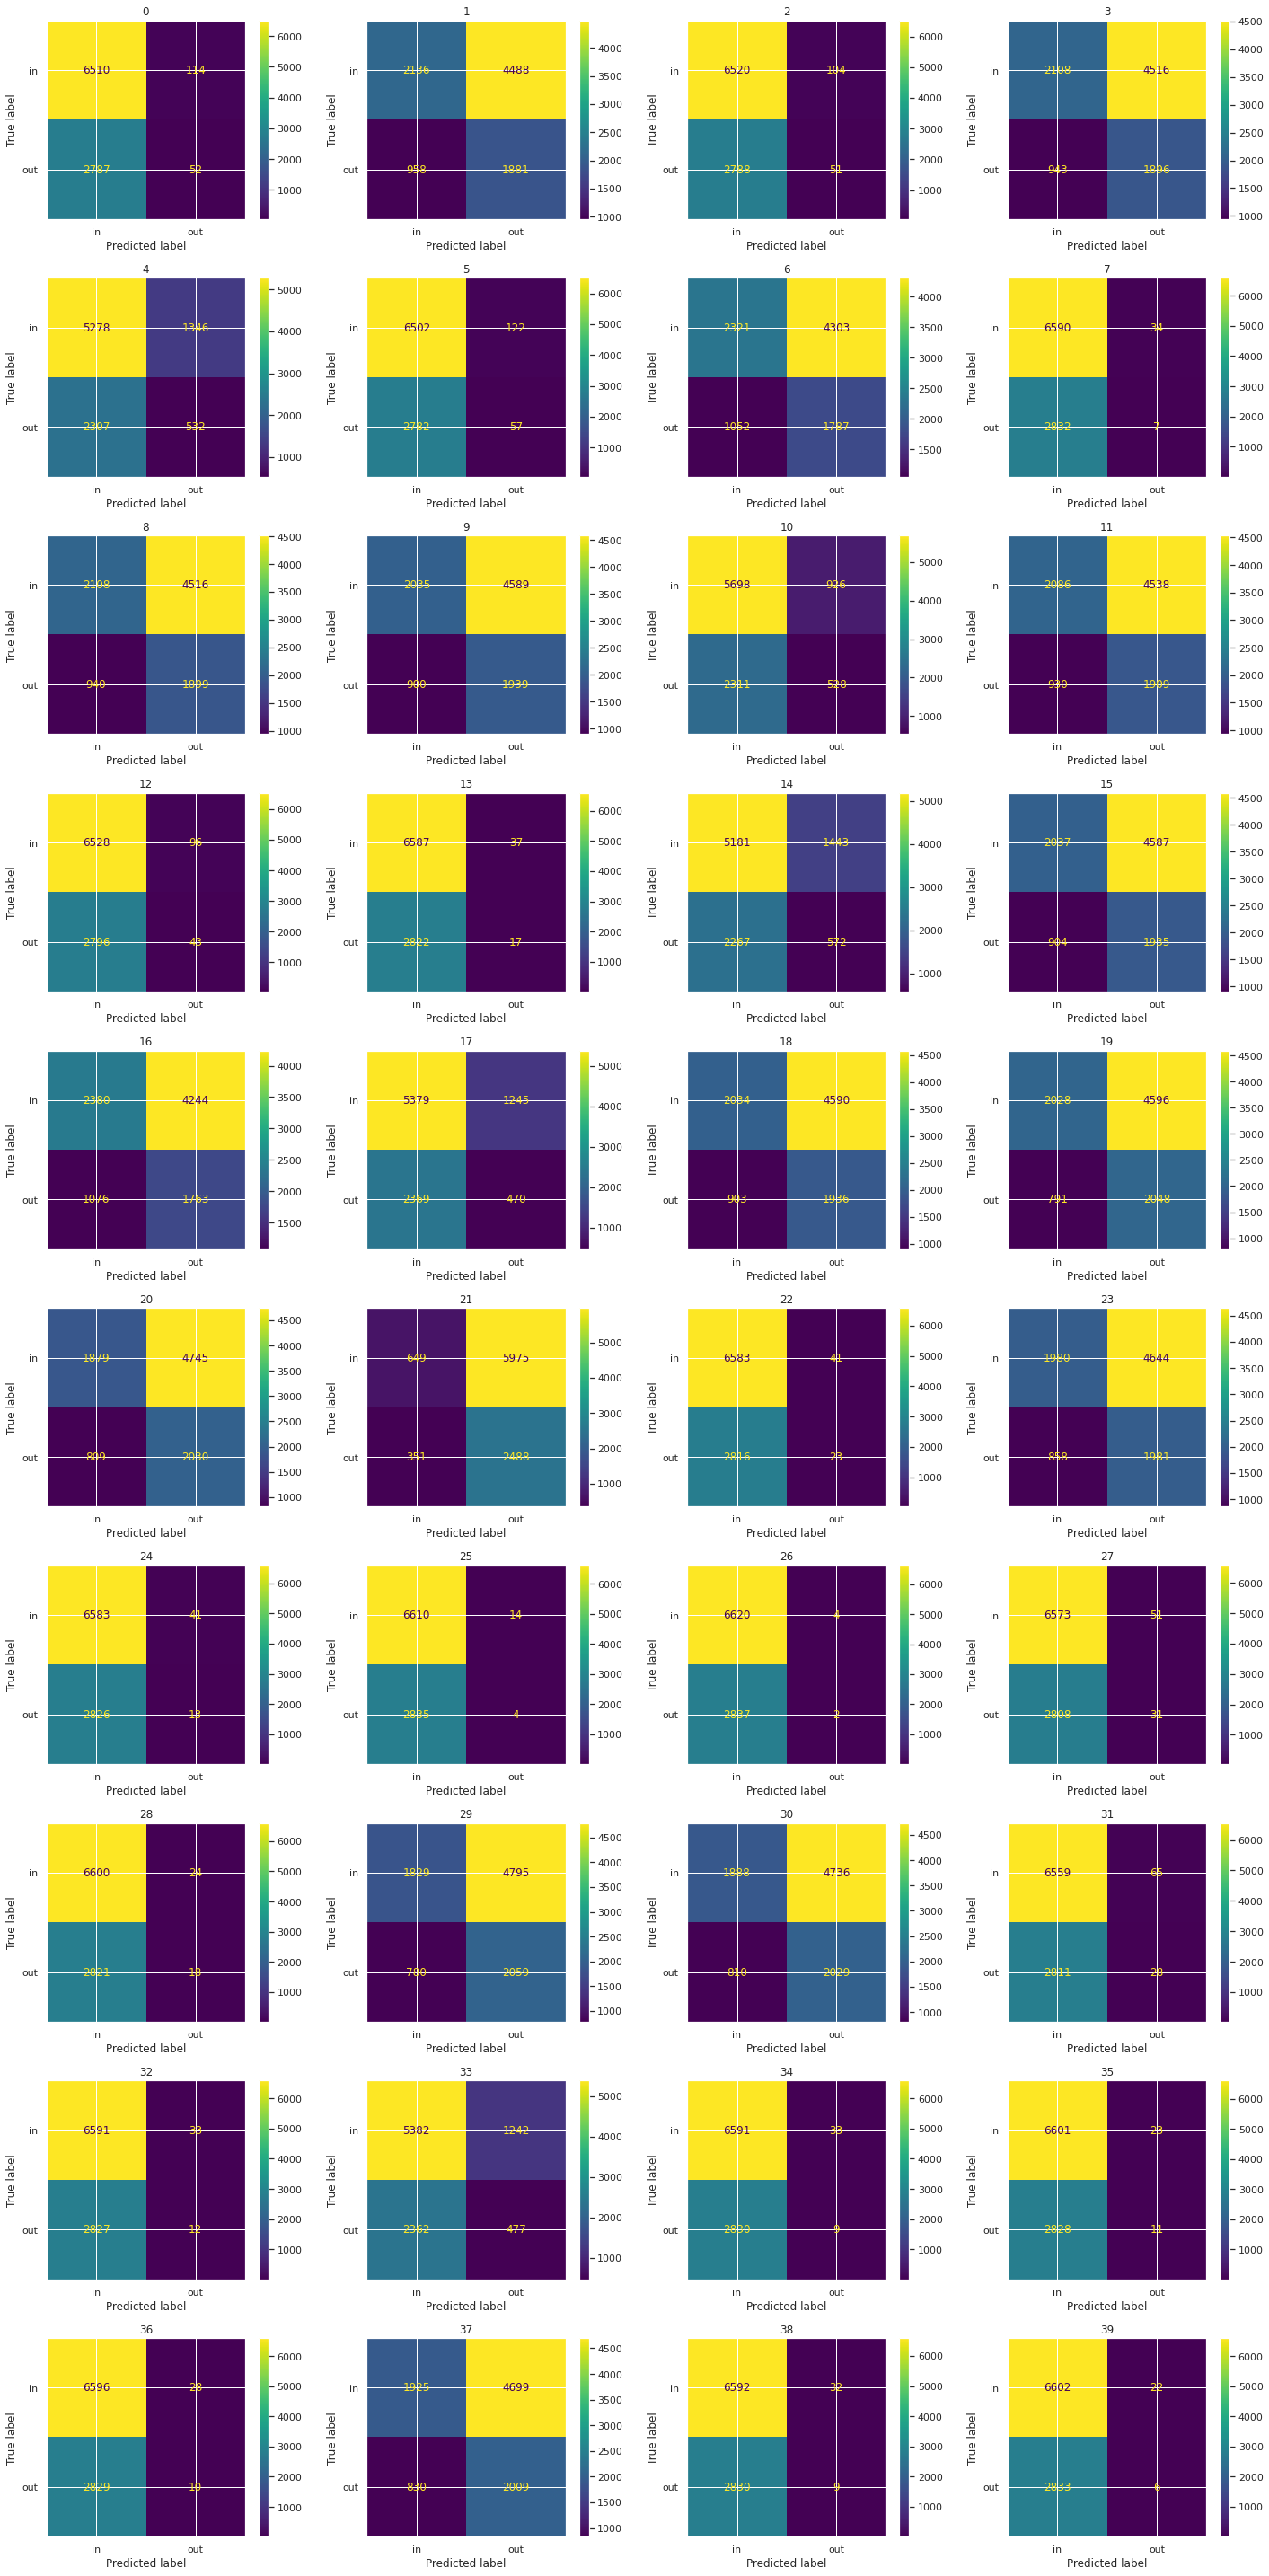

In [37]:
fig, axs = plt.subplots(nrows=10, ncols=4, figsize=(20, 40))
axes = axs.ravel()
for i, (a0, a1, ax) in enumerate(zip(ATTACK_0, ATTACK_1, axes)):
    IN_0_ = a0.predict(TRAIN_0)
    IN_1_ = a1.predict(TRAIN_1)
    OUT_0_ = a0.predict(TEST_0)
    OUT_1_ = a1.predict(TEST_1)
    ##
    INS_ = np.concatenate([IN_0_, IN_1_])
    INS_LAB_ = np.array(["in"] * len(INS_))
    OUTS_ = np.concatenate([OUT_0_, OUT_1_])
    OUTS_LAB_ = np.array(["out"] * len(OUTS_))
    ##
    INOUT_ = np.concatenate([INS_, OUTS_])
    INOUT_LAB_ = np.concatenate([INS_LAB_, OUTS_LAB_])
    ##
    ax.set_title(f"{i}")
    ConfusionMatrixDisplay.from_predictions(INOUT_LAB_, INOUT_, ax=ax)

plt.tight_layout()

# A single shadow model for both labels

## $5$ elements per quantile

In [38]:
BB_DATA = "../BB_DATA/clusters_representatives_quantiles_5_40.csv"

In [39]:
loaded = np.load(BASE_BB_DATA_PATH.format(n_samples=5), allow_pickle=True)
for k in loaded.keys():
    print(k, end=" ")
x_train = loaded["x_train"]
x_test = loaded["x_test"]
y_train = loaded["y_train"]
y_test = loaded["y_test"]
x_test_clustered = loaded["x_test_clustered"]
y_test_clustered = loaded["y_test_clustered"]

x_train x_test y_train y_test x_test_clustered y_test_clustered 

In [41]:
ATTACK_SINGLE = []

for index in range(len(x_test_clustered)):
    atk_single = get_attack_mod(index, base_folder="/home/gerardozinno/Desktop/ExperimentsResult/EXPERIMENT_TRAINSET_SHADOW_06/diva_results_shadow_nsamples_5_06train/gaussian/same", one_model=True)
    ATTACK_SINGLE.append(atk_single[0])
assert (len(ATTACK_SINGLE) == len(x_test_clustered))
        
ensemble_single = HardVotingClassifier(classifiers=ATTACK_SINGLE)

In [42]:
TRAIN_PREDICTIONS = black_box.predict_proba(x_train)
TEST_PREDICTIONS  = black_box.predict_proba(x_test)

In [43]:
INS = ensemble_single.predict(TRAIN_PREDICTIONS)
INS_LAB = np.array(["in"] * len(INS))
OUTS = ensemble_single.predict(TEST_PREDICTIONS)
OUTS_LAB = np.array(["out"] * len(OUTS))

In [44]:
number_even_in = len([x for x in INS if x == "even"])
number_even_out = len([x for x in OUTS if x == "even"])
print(f"even_in = {number_even_in/len(INS)}")
print(F"even_out = {number_even_out/len(OUTS)}")

even_in = 0.0006038647342995169
even_out = 0.0


In [45]:
INOUT = np.concatenate([INS, OUTS])
EVEN_MASK = INOUT != "even" # to mask away the even values
INOUT_LAB = np.concatenate([INS_LAB, OUTS_LAB])

In [46]:
print(classification_report(INOUT_LAB[EVEN_MASK], INOUT[EVEN_MASK]))

              precision    recall  f1-score   support

          in       0.70      1.00      0.82      6620
         out       0.08      0.00      0.00      2839

    accuracy                           0.70      9459
   macro avg       0.39      0.50      0.41      9459
weighted avg       0.51      0.70      0.58      9459



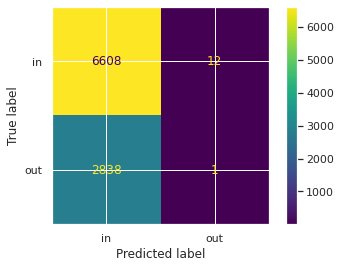

In [47]:
ConfusionMatrixDisplay.from_predictions(INOUT_LAB[EVEN_MASK], INOUT[EVEN_MASK])

### Checking if the attack models are majority classifiers


5 elem. per quantile

In [48]:
BB_DATA = "../BB_DATA/clusters_representatives_quantiles_5_40.csv"

In [49]:
loaded = np.load(BASE_BB_DATA_PATH.format(n_samples=5), allow_pickle=True)
for k in loaded.keys():
    print(k, end=" ")
x_train = loaded["x_train"]
x_test = loaded["x_test"]
y_train = loaded["y_train"]
y_test = loaded["y_test"]
x_test_clustered = loaded["x_test_clustered"]
y_test_clustered = loaded["y_test_clustered"]

x_train x_test y_train y_test x_test_clustered y_test_clustered 

In [50]:
print(len(x_test_clustered))

40


The attack models turn out to be Majority classifiers

In [51]:
print(len(ATTACK_SINGLE))

40


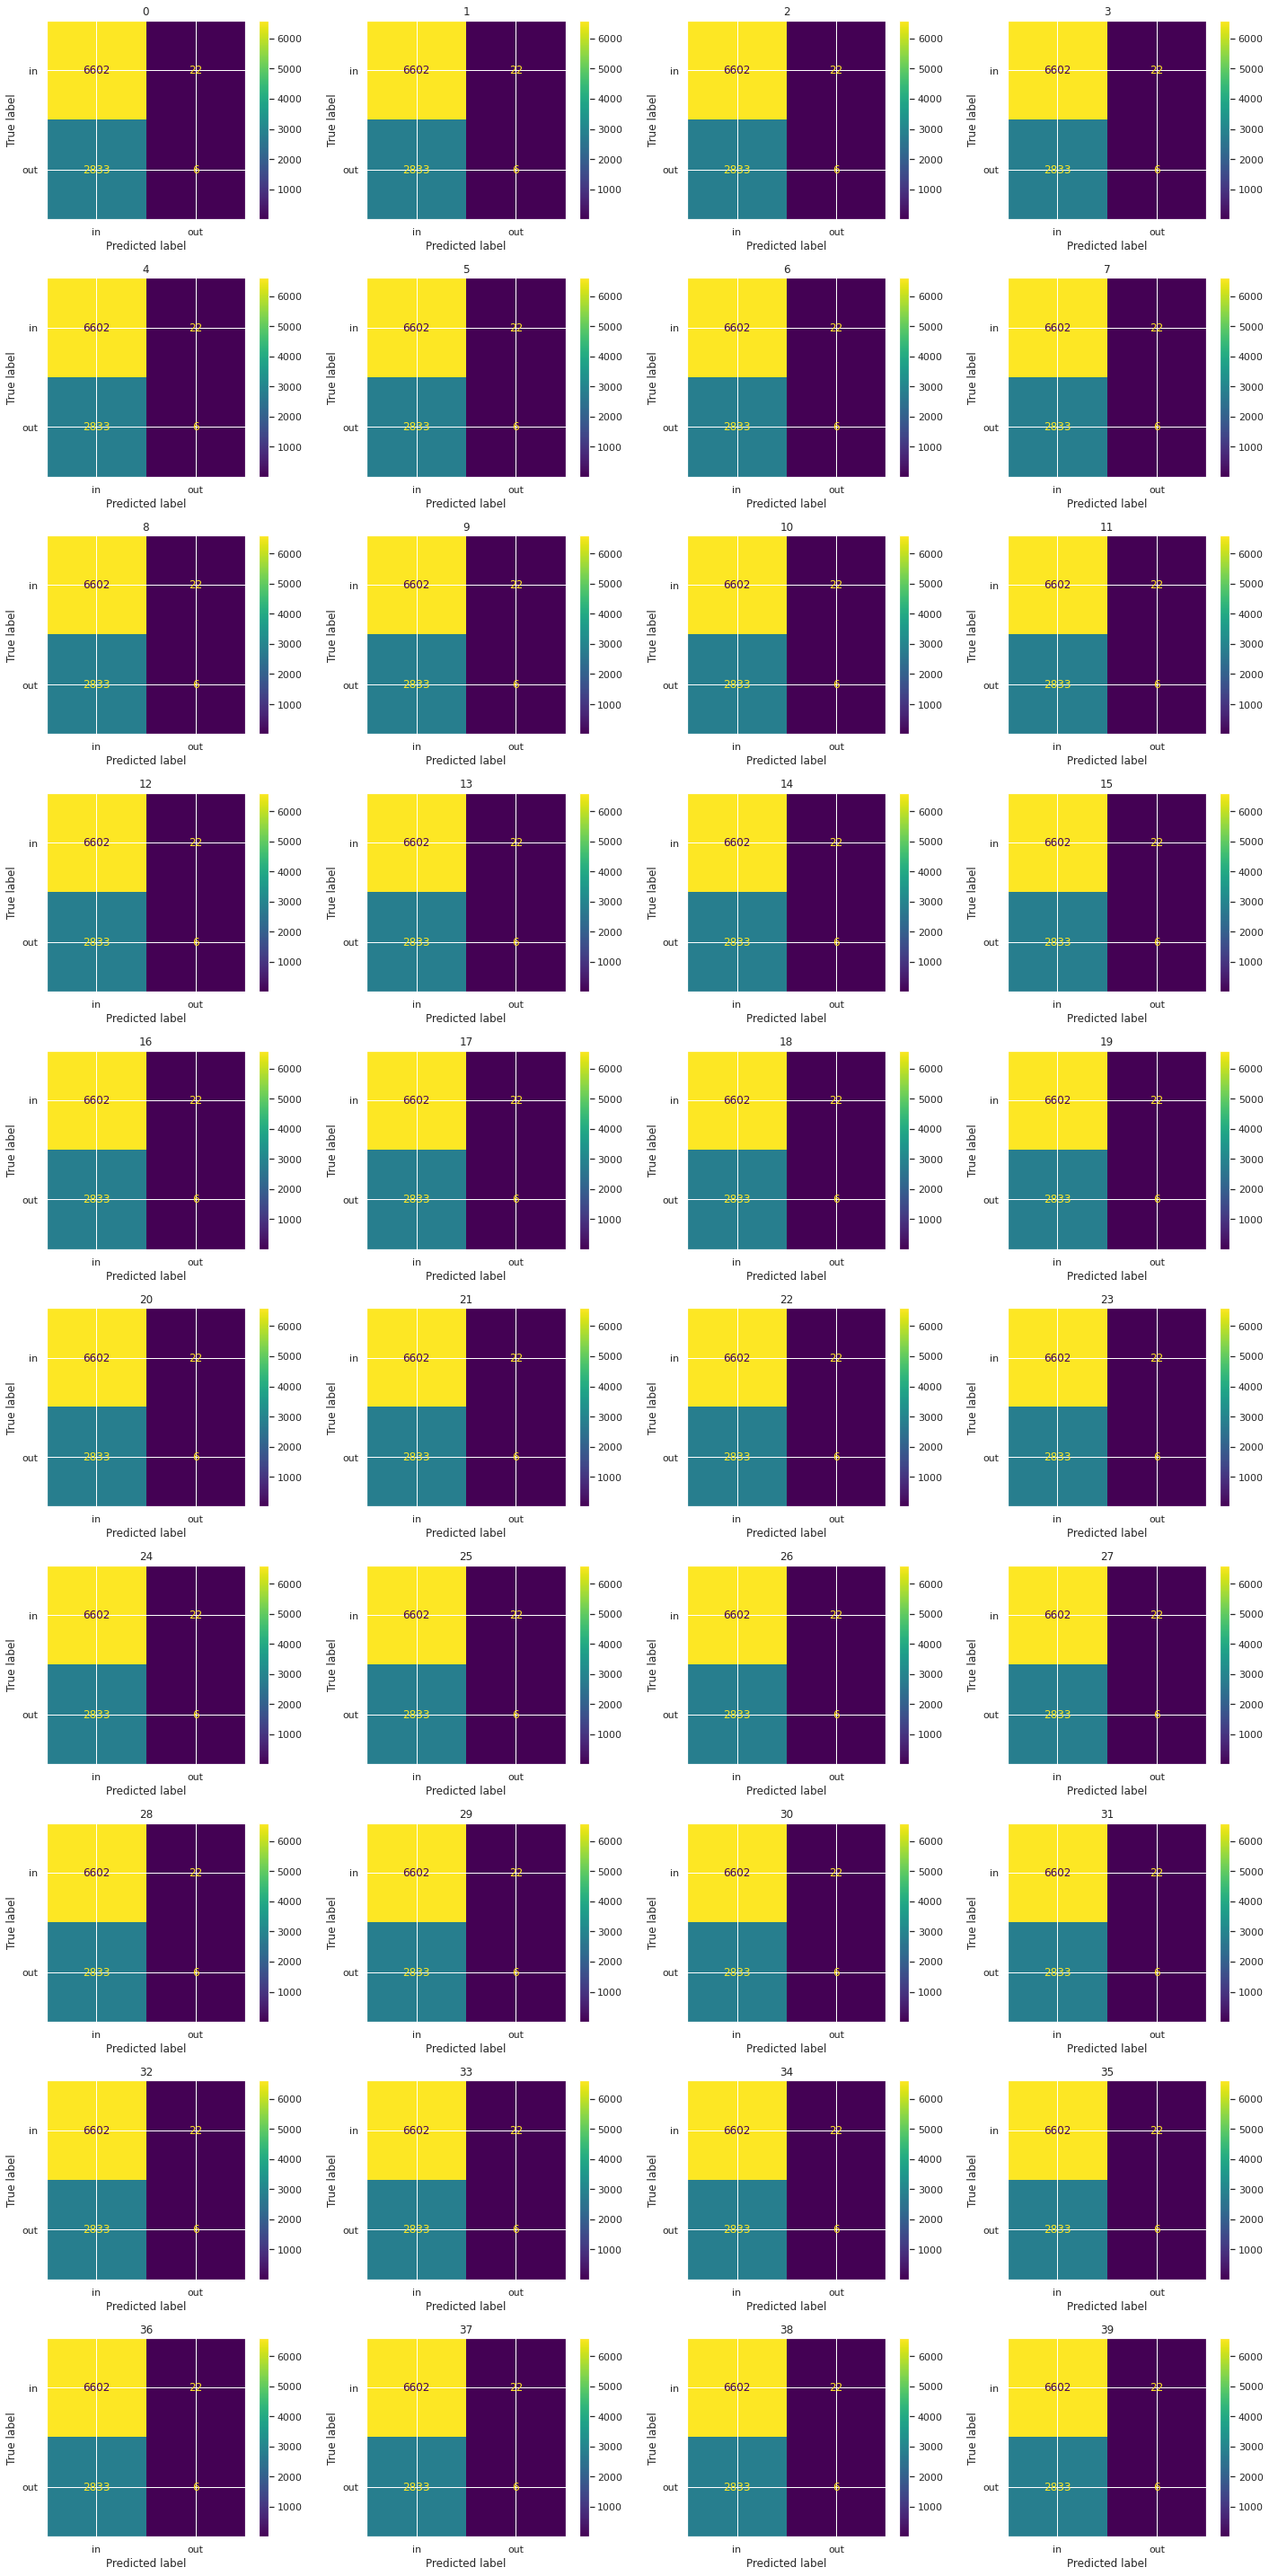

In [52]:
fig, axs = plt.subplots(nrows=10, ncols=4, figsize=(20, 40))
axes = axs.ravel()
for i, (atks, ax) in enumerate(zip(ATTACK_SINGLE, axes)):
    INS = ensemble_single.predict(TRAIN_PREDICTIONS)
    INS_LAB = np.array(["in"] * len(INS))
    OUTS = ensemble_single.predict(TEST_PREDICTIONS)
    OUTS_LAB = np.array(["out"] * len(OUTS))
    ##
    INOUT_ = np.concatenate([INS_, OUTS_])
    INOUT_LAB_ = np.concatenate([INS_LAB_, OUTS_LAB_])
    ##
    ax.set_title(f"{i}")
    ConfusionMatrixDisplay.from_predictions(INOUT_LAB_, INOUT_, ax=ax)

plt.tight_layout()